# Instalamos librerias

In [1]:
!pip install pandas
!pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 8.6 MB/s eta 0:00:00


# Cargamos librerias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize, Bounds, dual_annealing
from scipy.signal import TransferFunction, freqresp, bode

# Diagrama de bode

El diagrama de bode es una forma de representar la respuesta en frecuencia de un sistema. Este diagrama está dividido en dos partes, una para la magnitud y otra para el ángulo de fase.

## Diagrama de bode de la mágnitud
En este diagrama, la componente $x$ es la frecuancia en escala logaritmica, mientras que la componente $y$ es $20\log_{10}(G(j\omega)$. La razón por la que se utiliza la escala logaritmica para representar la magnitud, es por la siguiente propiedad de los logaritmos. Sea:

$$\|G(j\omega)\| = \frac{K\|(j\omega+z_1)\|\|(j\omega+z_2)\|...\|(j\omega+z_k)\|}{(j\omega)^m\|(j\omega+p_1)\|\|(j\omega+p_2)\|...\|(j\omega+p_n)\|}$$

En escala logaritma esta ecuación se simplifica a:

$$20log\|G(j\omega)\|=20\log K+20\log(\|j\omega+z_1\|)+20\log(\|j\omega+z_2\|)...+20\log(\|j\omega+z_k\|)-20\log (\|s^m\|)-20\log(\|j\omega+p_1\|)-20\log(\|j\omega+p_2\|)...-20\log(\|j\omega+p_n\|)$$

 De esta forma podemos ver la contribución de cada factor añadido en la respuesta dinámica del sistema.

 ## Diagrama de bode de angulo de fase

 El diagrama de fase no es otra cosa que la gráfica del ángulo de fase de $G(j\omega)$ con respecto a la frecuencia en escala logaritmica. A continuación se presenta un ejemplo del diagrama de bode, obtenido usando la librería scipy.signal, para la función de transferencia:
 $$G(s) = \frac{8.88*10^{-4}}{s^3+0.466s^2+0.0477s+1.11*10^{-3}} $$

TransferFunctionContinuous(
array([0.000888]),
array([1.     , 0.466  , 0.0477 , 0.00111]),
dt: None
)


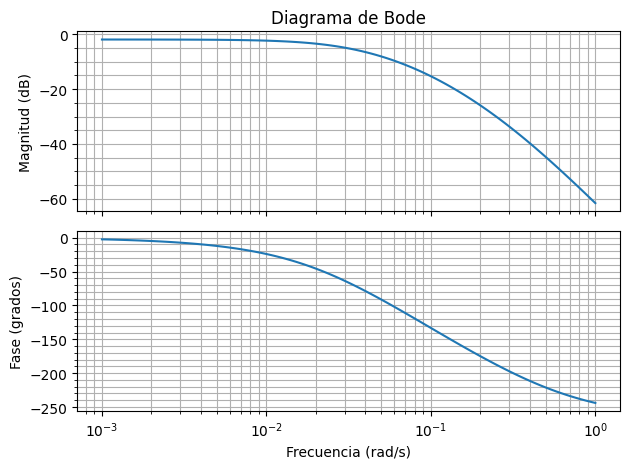

In [3]:
# Definir función de transferencia:
num = [8.88e-4]
den = [1, 0.466, 0.0477, 1.11e-3]
system = TransferFunction(num, den)
print(system)
# Obtener respuesta en frecuencia
w, mag, phase = bode(system)

# Graficar diagrama de Bode
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Subgráfico de magnitud
ax1.semilogx(w, mag)
ax1.set_ylabel('Magnitud (dB)')
ax1.set_title('Diagrama de Bode')
ax1.grid(True, which='both')  # Grilla principal y secundaria
ax1.minorticks_on()

# Subgráfico de fase
ax2.semilogx(w, phase)
ax2.set_xlabel('Frecuencia (rad/s)')
ax2.set_ylabel('Fase (grados)')
ax2.grid(True, which='both')  # Grilla principal y secundaria
ax2.minorticks_on()

plt.tight_layout()
plt.show()


## Obtener modelo a partir de la respuesta en frecuencia.

Supongamos que tenemos una planta y queremos obtener su modelo. Para eso, vamos a utilizar una entrada a diferentes frecuencias. En este ejemplo utilizaremos la función logspace para generar 300 frecuencias de $10^0$ hasta $10^2$. Dichas frecuencias las vamos a guardar en un archivo en excel, llamado datos_bode_generados. Note que los archivos quedan guardados en la carpeta de archivos.

In [4]:
# Planta simulada:
num = [8.88e-4]
den = [1, 0.466, 0.0477, 1.11e-3]
system = TransferFunction(num, den)

# Frecuencia (logspace para análisis de Bode)
frequencies = np.logspace(0, 2, 300)
w, mag, phase = bode(system, w=frequencies)

# Crear DataFrame
df = pd.DataFrame({
    'frecuencia (rad/s)': w,
    'magnitud (dB)': mag,
    'fase (grados)': phase
})

# Guardar como CSV
csv_path = 'datos_bode_generados.csv'
df.to_csv(csv_path, index=False)

csv_path  # Mostrar ruta del archivo generado para descarga o uso posterior


[  1.           1.01552113   1.03128316   1.04728984   1.06354496
   1.08005237   1.09681601   1.11383983   1.13112788   1.14868426
   1.16651313   1.18461873   1.20300535   1.22167735   1.24063916
   1.25989528   1.27945027   1.29930878   1.31947552   1.33995527
   1.36075289   1.38187331   1.40332154   1.42510267   1.44722187
   1.46968439   1.49249555   1.51566076   1.53918552   1.56307542
   1.58733611   1.61197336   1.636993     1.66240098   1.68820332
   1.71440614   1.74101565   1.76803818   1.79548012   1.823348
   1.85164842   1.88038809   1.90957383   1.93921257   1.96931134
   1.99987727   2.03091762   2.06243975   2.09445114   2.12695939
   2.15997219   2.1934974    2.22754295   2.26211693   2.29722754
   2.3328831    2.36909207   2.40586305   2.44320476   2.48112606
   2.51963593   2.55874352   2.5984581    2.6387891    2.67974609
   2.72133877   2.76357701   2.80647085   2.85003044   2.89426612
   2.9391884    2.98480792   3.0311355    3.07818214   3.125959
   3.17447741 

'datos_bode_generados.csv'

Queremos ahora obtener el modelo a partir de los datos. El flujo de trabajo que utilizaremos será:
1. Cargar los datos
2. Establecer la función objetivo
3. Asumir el número de polos y ceros del sistema
4. Optimizar
5. Verificar

## 1. Cargar los datos
Para cargar los datos utilizaremos la librería pandas. Es el siguiente link encontrará un buen tutorial para aprender los detalles de como utilizar pandas para cargar archivos CSV: [Leer CSV con pandas – DataCamp Tutorial](https://www.datacamp.com/tutorial/pandas-read-csv?utm_cid=21057859163&utm_aid=157296744657&utm_campaign=230119_1-ps-other~dsa~tofu_2-b2c_3-latam-en_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na&utm_loc=9199230-&utm_mtd=-c&utm_kw=&utm_source=google&utm_medium=paid_search&utm_content=ps-other~latam-en~dsa~tofu~tutorial~python&gad_source=1&gad_campaignid=21057859163&gbraid=0AAAAADQ9WsGpV8m_OQN9Ls2w6-Jz2jG2i&gclid=Cj0KCQjwgpzIBhCOARIsABZm7vHT0c3m4kB6HX7LeUHWFZZvFXCWRVQbPK2ufjhFkGvHrGLWyesGzJoaAkJiEALw_wcB)

El código siguiente muestra como subir los datos y guardarlos.

In [5]:
# Leer datos desde archivo CSV
df = pd.read_csv('datos_bode_generados.csv')
w = df['frecuencia (rad/s)'].to_numpy()
mag = df['magnitud (dB)'].to_numpy()
phase = df['fase (grados)'].to_numpy()

## 2. Establer la función objetivo

La función objetivo es una función de error, la cual la plantearemos con la siguiente expresión:
$$\text{Error} = \sum_{i=0}^N(\text{AR}_{\text{exp}}(\omega_i)-\text{AR}_{\text{model}}(\omega_i))^2+(\theta_{exp}(\omega_i)-\theta_{model}(\omega_i))^2$$

En donde: $AR_{exp}$ es el amplitude ratio obtenido de forma experimental, mientras que $AR_{model}$ es el obtenido a partir del modelo. Similarmente, $\theta_{exp}$ es el ángulo de fase obtenido experimentalmente, mientras que $\theta_{model}$ es el ángulo obtenido a partir el modelo. Tanto $AR$ como $\theta$ son evaluados a las frecuencias $\omega_i$.

## 3. Asumir el número de polos y zeros del sistema

Una vez establecida la función objetivo, necesitamos establer el tipo de función de transferencia que queremos ajustar a nuestro sistema. Con el tipo de función de transferencia nos referimos al número de polos y zeros que tendrá nuestra función. De esta forma, si la función de transferencia que queremos ajustar tiene 1 zero y 3 polos entonces esta tendrá la siguiente forma:

$$ G(s) = \frac{p_1s+p_2}{s^3+p_3s^2+p_4s+p_5}$$

En donde los parámetros $p_1$, $p_2$, $p_3$, $p_4$ y $p_5$ son los parámetros que queremos buscar para que nuestra función objetivo se ajuste a los datos obtenidos experimentalmente. De manera general, el número de parámetros de la función de transferencia estará dada por:
$$
\text{número de parámetros} =
\underbrace{(\text{número de ceros} + 1)}_{\text{parámetros correspondientes a los ceros}}
+ \underbrace{(\text{número de polos})}_{\text{parámetros correspondientes a los polos}}
$$
Esta estructura resulta práctica para crear nuestra función de transferencia, ya que permite distiguir automaticamente los coefficientes del numerador y del denominador necesarios para utilizar la librería de control. El siguiente código plantea las funciones necesarias para crear la función de transferencia modelos y para evaluar nuestra función de error.

In [6]:
n_zeros = 0
n_polos = 3
def construir_tf(params):
            num = params[:n_zeros + 1]
            den = np.concatenate(([1.0], params[n_zeros + 1:]))
            return num, den

def modelo_freqresp(params, w):
            num, den = construir_tf(params)
            sys = TransferFunction(num, den)
            print(sys)
            _, mag_c, phase_c = bode(sys, w)
            return mag_c, phase_c

def error(params):
            mag_est, phase_est = modelo_freqresp(params, w)
            e_mag = np.sum((mag_est - mag)**2)
            e_phase = np.sum((phase_est - phase)**2)
            error = e_mag +  e_phase
            print('error: ', error)
            return error

## 4. Optimizar
La función para optimizar que escogimos se llama "dual annealing", suficiente con decir que esta función establece una serie de reglas para encontrar los mejores parámetros que se ajusten a los datos entregados. Para obtener más información sobre la función "dual annealing", visite el siguiente link:
[tutorial dual annealing](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.dual_annealing.html).

La función dual annealing que utilizaremos, requiere que le indiquemos la función objetivo y un valor inicial, como valor de entrada. Además, require que le indiquemos los límites de exploración para los valores de los parámetros.

Hablemos primero del valor inicial, en el caso de nuestro problema sabemos que la función de transferencia no tiene ceros y tiene 3 polos, con lo cual usamos la siguiente función para definir el valor inicial de nuestros parametros.


In [13]:
n_zeros = 0
n_polos = 3
params0 = np.concatenate((np.ones(n_zeros + 1), np.ones(n_polos))) # todos los parametros los inicializamos con un valor random, en este caso utilizamos 1.
print('Valores iniciales de los parametros a optimizar: ')
display(params0)

Valores iniciales de los parametros a optimizar: 


array([1., 1., 1., 1.])

Ahora necesitamos delimitar los límites de los parametros. Los coeficientes del polinomio del numerador puede tomar valores negativos, luego las fronteras de los coeficientes de este polinomio pueden ir de un valor arbitrariamente negativo, hasta otro arbitrariamente positivo. Por otro lado, sabemos del criterio de Routh-Hurwitz que los coeficientes del polinomio del denominador deben ser positivos, sino el sistema será inestable. Luego, los límites de los coeficientes iran desde un valor muy pequeño, hasta un valor arbitrariamente grande. El siguiente código muestra como setear los límites del optimizador.

In [20]:
bounds = [(-10, 10)] * (n_zeros + 1) + [(1e-8, 1e3)] * n_polos
print(bounds)

[(-10, 10), (1e-08, 1000.0), (1e-08, 1000.0), (1e-08, 1000.0)]
<class 'scipy.optimize._optimize.OptimizeResult'>


Ya estamos listo para ejecutar nuestro optimizador. El optimizador regresa un objeto de una clase llamada "scipy.optimize._optimize.OptimizeResult", este objeto contiene la evaluación de la función, los parámetros óptimos, entre otra información útil.

Streaming output truncated to the last 5000 lines.
)
error:  17915718.465734504
TransferFunctionContinuous(
array([0.000888]),
array([1.        , 0.46600303, 0.04768649, 7.98847693]),
dt: None
)
error:  377355.57651087
TransferFunctionContinuous(
array([-0.19410324]),
array([1.        , 1.08403104, 0.04797997, 2.59444015]),
dt: None
)
error:  10758549.92292471
TransferFunctionContinuous(
array([0.037044]),
array([1.00000000e+00, 9.55929275e-02, 6.30763236e+00, 1.30929373e+02]),
dt: None
)
error:  1336797.5228505246
TransferFunctionContinuous(
array([0.00099443]),
array([1.00000000e+00, 1.74269163e+01, 9.99938388e+02, 1.14416856e-02]),
dt: None
)
error:  17523643.326477826
TransferFunctionContinuous(
array([0.04964742]),
array([ 1.        , 24.26792819,  0.04597279,  0.04942888]),
dt: None
)
error:  1205187.7795231703
TransferFunctionContinuous(
array([0.06546156]),
array([1.        , 0.46600303, 0.04768649, 0.0011086 ]),
dt: None
)
error:  418539.3327206597
TransferFunctionContinuous(


0.000887999546686833/(1.0*s**3 + 0.46600303220801*s**2 + 0.0476864858113318*s + 0.00110859956547232)

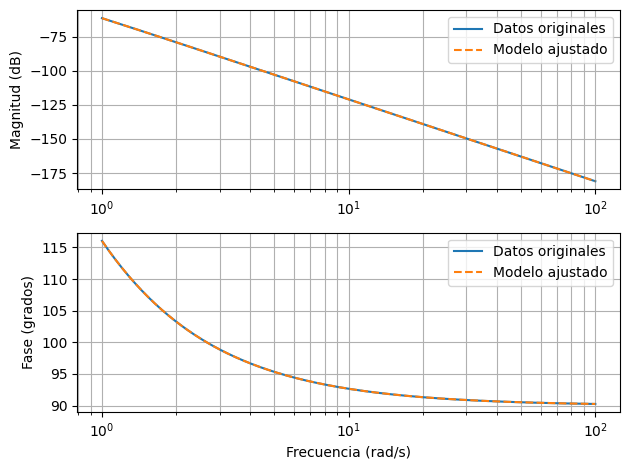

In [17]:
best_error = np.inf
best_params = None
best_order = None
best_tf = None
res = dual_annealing(error, bounds)

if res.success:
    best_error = res.fun
    best_params = res.x
    best_order = (n_zeros, n_polos)
    num_best, den_best = construir_tf(res.x)
    best_tf = TransferFunction(num_best, den_best)



## 5. Validación
Una vez completamos el proceso, simplemente ploteamos los resultados para verificar que el modelo sí se ajuste a los datos experimentales. Note que la aproximación es tan buena como que tan buena sea su interpretación de los datos obtenidos experimentalmente y su entendimiento del modelo dinámico del sistema.

0.000887999546686833/(1.0*s**3 + 0.46600303220801*s**2 + 0.0476864858113318*s + 0.00110859956547232)

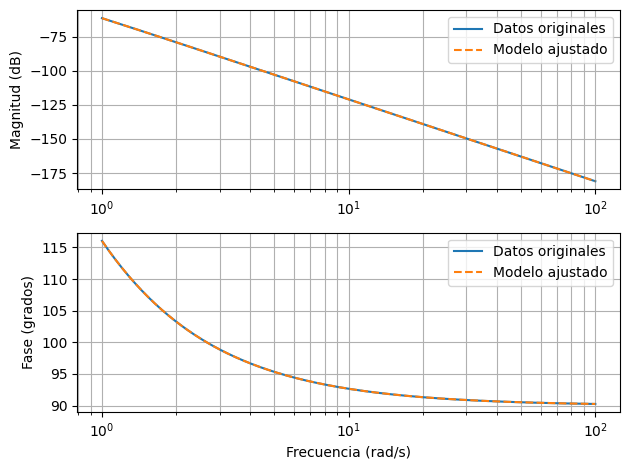

In [19]:
# Visualización y función estimada
if best_tf is not None:
    _, H_best = freqresp(best_tf, w)
    mag_fit = 20 * np.log10(np.abs(H_best))
    phase_fit = np.angle(H_best, deg=True)

    from sympy import symbols, simplify, Eq, latex
    from sympy.abc import s
    from IPython.display import display, Math

    num_fit, den_fit = best_tf.num, best_tf.den
    num_expr = sum(coef * s**i for coef, i in zip(num_fit, reversed(range(len(num_fit)))))
    den_expr = sum(coef * s**i for coef, i in zip(den_fit, reversed(range(len(den_fit)))))
    G_s = simplify(num_expr / den_expr)
    display(G_s)

    # Graficar comparación
    plt.figure()

    plt.subplot(2, 1, 1)
    plt.semilogx(w, mag, label='Datos originales')
    plt.semilogx(w, mag_fit, '--', label='Modelo ajustado')
    plt.ylabel('Magnitud (dB)')
    plt.grid(True, which='both')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.semilogx(w, phase, label='Datos originales')
    plt.semilogx(w, phase_fit, '--', label='Modelo ajustado')
    plt.xlabel('Frecuencia (rad/s)')
    plt.ylabel('Fase (grados)')
    plt.grid(True, which='both')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No se encontró un modelo factible con coeficientes positivos.")